In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numba.decorators import jit
from random import randint
import itertools

In [13]:
def get_undirected_edges(g):
    return tuple(sorted(tuple(sorted(e)) for e in g.edges))

def has_cycles(g):
    try:
        c = nx.algorithms.cycles.find_cycle(g)
        return len(c) > 0
    except nx.NetworkXNoCycle:
        return False

def edges_not_from(t, g):
    t_edges = set(get_undirected_edges(t))
    g_edges = set(get_undirected_edges(g))
    return sorted(t_edges - g_edges)

def assert_is_spanning_tree_of(t, g):
    assert nx.is_connected(g)
    #assert has_cycles(g)
    assert t.nodes == g.nodes
    assert nx.is_connected(t)
    assert not has_cycles(t)
    assert not edges_not_from(t, g)

def is_spanning_tree_of(t, g):
    try:
        assert_is_spanning_tree_of(t, g)
        return True
    except AssertionError:
        return False

In [14]:
def make_random_graph(num_nodes, edge_prob=0.25, connected=False, cyclic=False):
    while True:
        g = nx.generators.random_graphs.fast_gnp_random_graph(num_nodes, edge_prob)
        if connected and not nx.is_connected(g):
            continue
        if cyclic and not has_cycles(g):
            continue
        return g

## Find a spanning tree

алгоритм поиска (в глубину) остовного дерева для простого связного графа:
1. красим все вершины (N штук) и рёбра синим
2. начинаем с произвольной вершины
3. красим текущую вершину красным
4. ищем смежные синие вершины, соединённые с текущей через синие рёбра
5. если есть, красим ребро красным и рекурсивно перемещаемся в такую
6. продолжаем, пока остались синие вершины
7. по окончании синие рёбра отбрасываем (это рёбра циклов);
   красные вершины (N штук) и рёбра (N-1 штук) - это остовный граф

In [91]:
def make_spanning_tree_stack(G, root=0):
    adj = [list(x.keys()) for x in G.adj.values()]
    verts = set([root])
    edges = set()
    stack = [root]
    while stack:
        v = stack.pop()
        for w in adj[v]:
            e = (v,w) if v < w else (w,v)
            if w in verts or e in edges:
                continue
            edges.add(e)
            verts.add(w)
            stack.append(w)
    return nx.from_edgelist(edges)

def make_spanning_tree_recursive(G, root=0):
    adj = [list(x.keys()) for x in G.adj.values()]
    verts = set()
    edges = set()
    def dfs(v):
        verts.add(v)
        for w in adj[v]:
            e = (v,w) if v < w else (w,v)
            if w in verts or e in edges:
                continue
            edges.add(e)
            dfs(w)
    dfs(root)
    return nx.from_edgelist(edges)

In [92]:
# test on many random samples
num_test = 1000
max_size = 10
for i in range(num_test):
    RG = make_random_graph(randint(3, max_size), connected=True, cyclic=True)
    STn = make_spanning_tree_stack(RG)
    STr = make_spanning_tree_recursive(RG)
    assert_is_spanning_tree_of(STn, RG)
    assert_is_spanning_tree_of(STr, RG)

## Some visual example

In [93]:
G = make_random_graph(10, connected=True, cyclic=True)
H = nx.minimum_spanning_tree(G)
T = make_spanning_tree_recursive(G)
is_spanning_tree_of(H, G), is_spanning_tree_of(T, G)

(True, True)

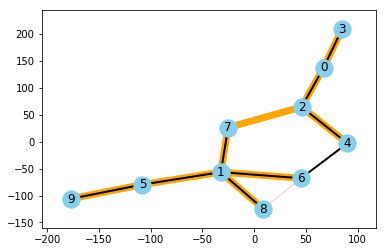

In [94]:
#G=RG; T=STr; H=STn;
pos = nx.nx_pydot.pydot_layout(G, prog='neato')
nx.draw_networkx_edges(G, pos=pos, width=1, edge_color='pink')
nx.draw_networkx_edges(H, pos=pos, width=7, edge_color='orange')
nx.draw_networkx_edges(T, pos=pos, width=2, edge_color='black')
nx.draw_networkx(G, pos=pos, width=0, with_labels=True, node_color='skyblue')